In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
Running on the GPU


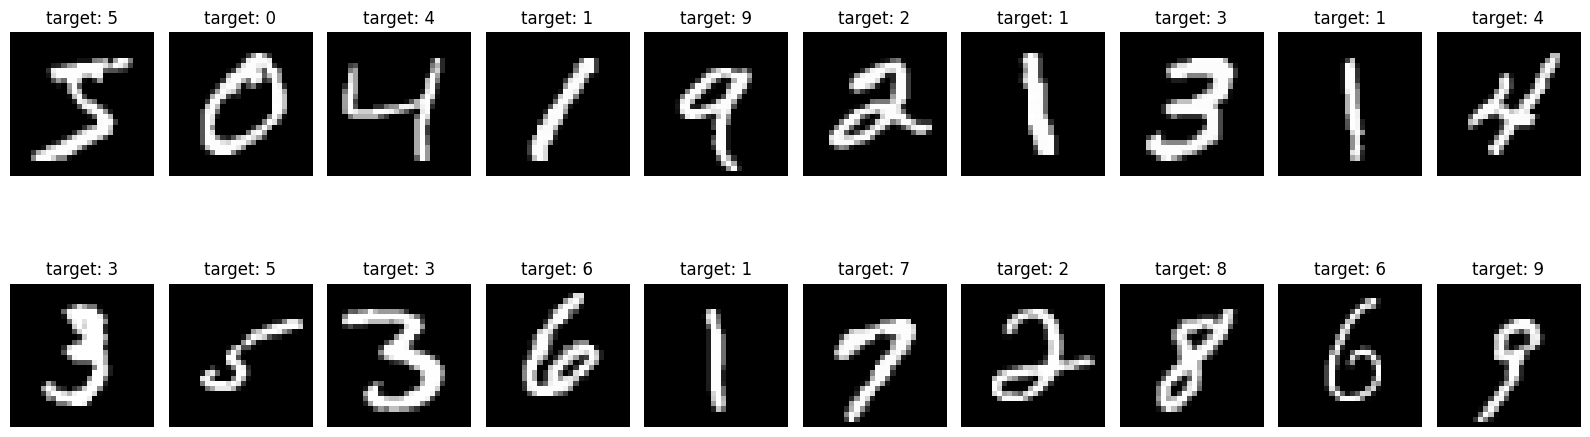

In [3]:
fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(loader.dataset.data[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {loader.dataset.targets[i]}")
    print(loader.dataset.data[i].shape)
    
plt.tight_layout()


if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
model = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/20, Loss: 0.005364
Epoch 2/20, Loss: 0.004983
Epoch 3/20, Loss: 0.004812
Epoch 4/20, Loss: 0.003551
Epoch 5/20, Loss: 0.003574
Epoch 6/20, Loss: 0.003775
Epoch 7/20, Loss: 0.002977
Epoch 8/20, Loss: 0.003055
Epoch 9/20, Loss: 0.002951
Epoch 10/20, Loss: 0.002723
Epoch 11/20, Loss: 0.002571
Epoch 12/20, Loss: 0.003315
Epoch 13/20, Loss: 0.002967
Epoch 14/20, Loss: 0.002884
Epoch 15/20, Loss: 0.003390
Epoch 16/20, Loss: 0.003075
Epoch 17/20, Loss: 0.003408
Epoch 18/20, Loss: 0.003083
Epoch 19/20, Loss: 0.002642
Epoch 20/20, Loss: 0.003380


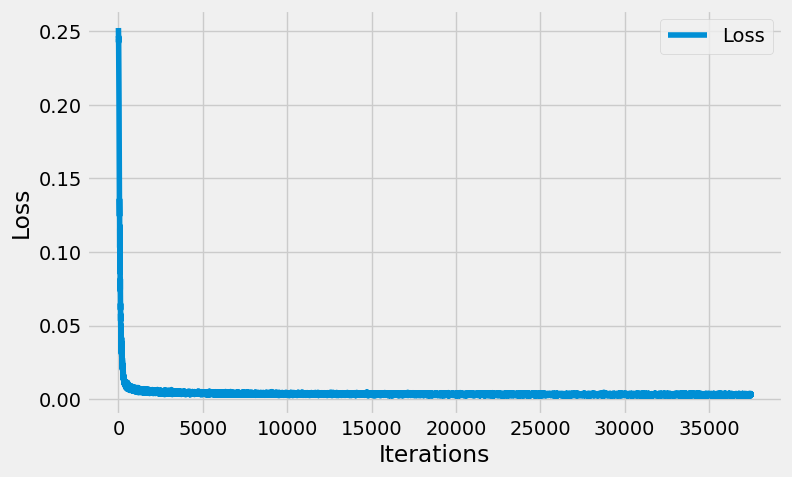

In [6]:
epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(images.size(0), -1, 28, 28).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


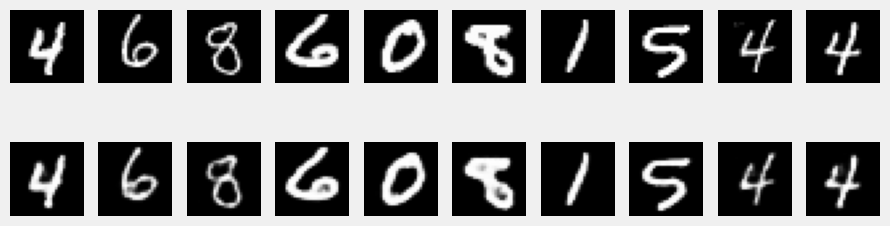

In [7]:
model.eval()
dataiter = iter(loader)
images, _ = next(dataiter)

images = images.view(images.size(0), -1, 28, 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()
